# Segmentation sémantique multi-classe_DeepLabV3+

## Introduction

La segmentation sémantique, dans le but d'attribuer des étiquettes sémantiques à chaque pixel d'une image, est une tâche essentielle de la vision par ordinateur. On a implémenté un modèle DeepLabV3+ pour la segmentation sémantique multi-classe. Nous utiliserons l'ensemble des données d'analyse humaine pour former notre modèle. L'ensemble des données du dataset CIHP contient 38 280 images humaines diverses. Chaque image dans CIHP est étiquetée avec des annotations pixel par pixel pour 20 catégories.

### References:

- [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)
- [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915)

## Préparation des données(CIHP)

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:22<00:00, 128MB/s]


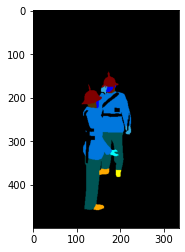

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
img = mpimg.imread(DATA_DIR+'/Categories/0000006.png')
imgplot = plt.imshow(img)
plt.show()

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50
train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES] #list of each image path
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES] #list of each image segmentation path
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]

In [5]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    tf.print("image",image)
    if mask:
        image = tf.image.decode_png(image, channels=1) #(None, None,1),(375, 500, 1), (421, 515, 1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE]) #(512,512, 1)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
        print(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)# Création des batchs
    return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

Tensor("sub:0", shape=(512, 512, 3), dtype=float32)
Tensor("sub:0", shape=(512, 512, 3), dtype=float32)


In [6]:
print((list(val_dataset.take(1).as_numpy_iterator())))

[(array([[[[-0.94509804, -0.9372549 , -0.92156863],
         [-0.9980699 , -0.9977941 , -0.9821078 ],
         [-0.91139704, -0.90401345, -0.8883272 ],
         ...,
         [-0.97046566, -0.97046566, -0.97046566],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ]],

        [[-0.9715303 , -0.96746325, -0.951777  ],
         [-0.96620953, -0.9624232 , -0.94673693],
         [-0.92362493, -0.9160201 , -0.9003338 ],
         ...,
         [-0.98180854, -0.98180854, -0.98180854],
         [-0.95091146, -0.95091146, -0.95091146],
         [-0.95091146, -0.95091146, -0.95091146]],

        [[-1.        , -1.        , -0.9843137 ],
         [-0.93600225, -0.92843485, -0.9127486 ],
         [-0.945063  , -0.9382221 , -0.92253584],
         ...,
         [-0.9948367 , -0.9948367 , -0.9948367 ],
         [-0.9118796 , -0.9118796 , -0.9118796 ],
         [-0.9118796 , -0.9118796 , -0.9118796 ]],

        ...,

        [[-0.94577205, -0.9379289 , 

## Implémentation du modèle DeepLabV3+

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales(traite les informations contextuelles multi-échelles en appliquant une convolution dilatée à plusieurs
échelles), while the decoder module refines the segmentation results along object boundaries(affine les résultats de la segmentation le long des limites de l'objet.).

Encodeur-Décodeur. Le module encodeur traite les informations contextuelles multi-échelles en appliquant une convolution dilatée à plusieurs échelles, tandis que le module décodeur affine les résultats de segmentation le long des limites de l'objet.									
Convolution dilatée : Avec la convolution dilatée, au fur et à mesure que nous progressons dans le réseau, nous pouvons maintenir le stride constant mais avec un champ de vision plus large sans augmenter le nombre de paramètres ou la quantité de calculs. 

In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [8]:
resnet50 = keras.applications.ResNet50()
resnet50.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [9]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output #(None, 14, 14, 256), (None, 32, 32, 256)
    print("xxxxx",x.shape)
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary() 

94781440/94765736 [==============================] - 1s 0us/step
xxxxx (None, 32, 32, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
   

## Entrainement

Epoch 1/25
250/250 [==============================] - 122s 396ms/step - loss: 1.2198 - accuracy: 0.6390 - val_loss: 2.4558 - val_accuracy: 0.5960
Epoch 2/25
250/250 [==============================] - 100s 401ms/step - loss: 0.9398 - accuracy: 0.7021 - val_loss: 2.1090 - val_accuracy: 0.5968
Epoch 3/25
250/250 [==============================] - 102s 407ms/step - loss: 0.8376 - accuracy: 0.7315 - val_loss: 1.2533 - val_accuracy: 0.6485
Epoch 4/25
250/250 [==============================] - 102s 406ms/step - loss: 0.7715 - accuracy: 0.7529 - val_loss: 1.0618 - val_accuracy: 0.6645
Epoch 5/25
250/250 [==============================] - 100s 401ms/step - loss: 0.7084 - accuracy: 0.7725 - val_loss: 1.0216 - val_accuracy: 0.6831
Epoch 6/25
250/250 [==============================] - 102s 407ms/step - loss: 0.6477 - accuracy: 0.7915 - val_loss: 0.9020 - val_accuracy: 0.7175
Epoch 7/25
250/250 [==============================] - 102s 406ms/step - loss: 0.5917 - accuracy: 0.8102 - val_loss: 0.9132 -

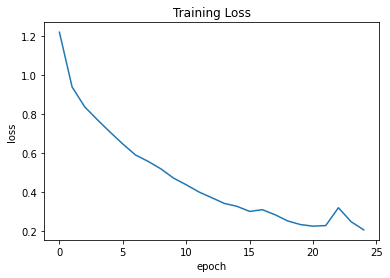

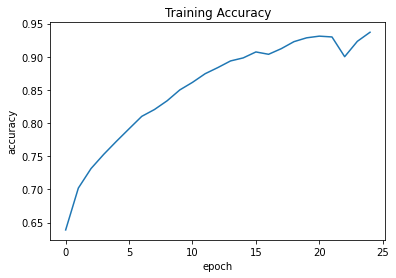

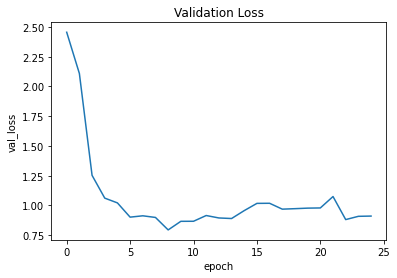

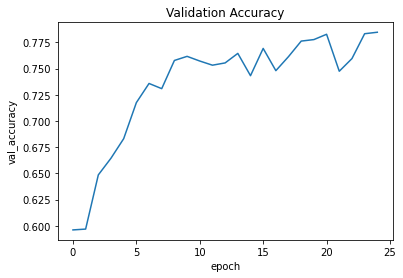

In [10]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

On obtient les résultats ci-dessus en entrainant le modèle sur une partie du dataset, on obtiendra de meilleurs résultats en entrainant le modèle sur le dataset entier.

## Inférence 

Les prédictions brutes du modèle représentent un tenseur de forme codé one-hot (N, 512, 512, 20) où chacun des 20 canaux est un masque binaire correspondant à une étiquette prédite. Afin de visualiser les résultats, nous les traçons sous forme de masques de segmentation où chaque pixel est représenté par une couleur unique correspondant à l'étiquette particulière prédite. 

In [11]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )


### Inference sur les données d'entrainements

tf.Tensor(
[[[-0.372549   -0.29411763 -0.2235294 ]
  [-0.47827816 -0.3998468  -0.32925856]
  [-0.5964154  -0.5190487  -0.45058978]
  ...
  [ 0.11943936  0.07809436 -0.06986058]
  [ 0.1175015   0.08642006 -0.0625996 ]
  [ 0.11372554  0.09019613 -0.05882353]]

 [[-0.3649816  -0.28655022 -0.215962  ]
  [-0.44885105 -0.37041968 -0.29983145]
  [-0.540362   -0.46196806 -0.39145464]
  ...
  [ 0.12597954  0.08463454 -0.0633204 ]
  [ 0.1250689   0.09398746 -0.05503219]
  [ 0.12129295  0.09776354 -0.05125612]]

 [[-0.40900737 -0.30842525 -0.23783702]
  [-0.47075152 -0.3701694  -0.29958117]
  [-0.5393218  -0.43873972 -0.3681515 ]
  ...
  [ 0.12722015  0.08587515 -0.06207979]
  [ 0.12534463  0.0942632  -0.05475646]
  [ 0.12156868  0.09803927 -0.05098039]]

 ...

 [[ 0.2037071   0.12527573  0.0546875 ]
  [ 0.19637632  0.11794496  0.04735672]
  [ 0.18541121  0.10697985  0.0363915 ]
  ...
  [-0.5905495  -0.51996124 -0.46505928]
  [-0.60051227 -0.52992404 -0.47502214]
  [-0.60784316 -0.5372549  -0.482

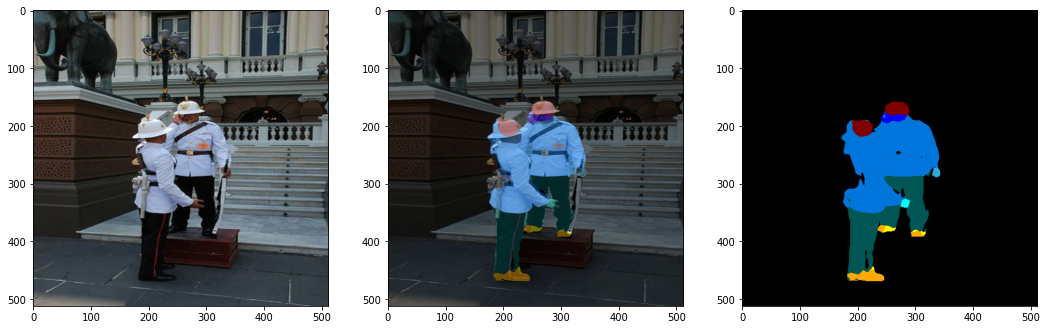

tf.Tensor(
[[[ 0.09803927  0.4901961   0.21568632]
  [ 0.10560668  0.4977635   0.22325373]
  [-0.2854473   0.09932601 -0.13826591]
  ...
  [ 0.12665439 -0.02190566 -0.15386027]
  [ 0.0798713  -0.06130517 -0.17055762]
  [ 0.01176476 -0.12941176 -0.2235294 ]]

 [[ 0.06426167  0.44515932  0.18190873]
  [ 0.14425147  0.5215279   0.26914072]
  [-0.12403625  0.24925804  0.01651859]
  ...
  [ 0.12643445 -0.01461941 -0.15032715]
  [ 0.0762502  -0.05742013 -0.17042565]
  [ 0.01176476 -0.12190562 -0.21977633]]

 [[ 0.03155637  0.39710474  0.15330887]
  [ 0.17759848  0.5365696   0.312505  ]
  [ 0.06968558  0.4284172   0.20507169]
  ...
  [ 0.12323606 -0.00353974 -0.1473828 ]
  [ 0.07127762 -0.04911697 -0.16929162]
  [ 0.01073837 -0.11064643 -0.21568626]]

 ...

 [[-0.7104626  -0.6555607  -0.71830577]
  [-0.6963181  -0.64141613 -0.7041612 ]
  [-0.6820017  -0.62709975 -0.68984485]
  ...
  [-0.4126668   0.1343472  -0.3516351 ]
  [-0.34567773  0.18619049 -0.2793985 ]
  [-0.3384651   0.20952821 -0.277

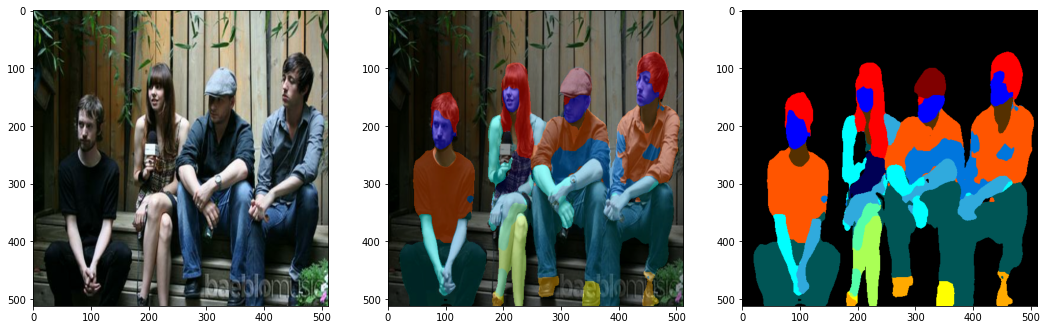

tf.Tensor(
[[[ 1.00000000e+00  9.84313726e-01  9.60784316e-01]
  [ 9.86014128e-01  9.56341863e-01  9.32812452e-01]
  [ 9.77887511e-01  9.46514964e-01  9.22985554e-01]
  ...
  [-6.24387264e-01 -5.28852642e-01 -6.44324422e-01]
  [-5.10516226e-01 -4.08555448e-01 -5.51432252e-01]
  [-4.19607818e-01 -3.17647040e-01 -4.74509776e-01]]

 [[ 1.00000000e+00  9.69178915e-01  9.45649505e-01]
  [ 9.86014128e-01  9.74942684e-01  9.44666147e-01]
  [ 9.96488333e-01  9.69217181e-01  9.44320560e-01]
  ...
  [-5.09509087e-01 -4.07774210e-01 -5.41846752e-01]
  [-3.86976898e-01 -2.85016119e-01 -4.27892923e-01]
  [-2.75827229e-01 -1.73866451e-01 -3.30729187e-01]]

 [[ 9.70465660e-01  9.61243868e-01  9.30330873e-01]
  [ 9.82812643e-01  9.87986445e-01  9.50080514e-01]
  [ 9.97166038e-01  9.90861297e-01  9.58531260e-01]
  ...
  [-5.48197031e-01 -4.61003363e-01 -5.88370085e-01]
  [-4.95450020e-01 -4.06655669e-01 -5.42949259e-01]
  [-4.62561250e-01 -3.60600471e-01 -5.17463207e-01]]

 ...

 [[ 2.46016979e-02 -5.3

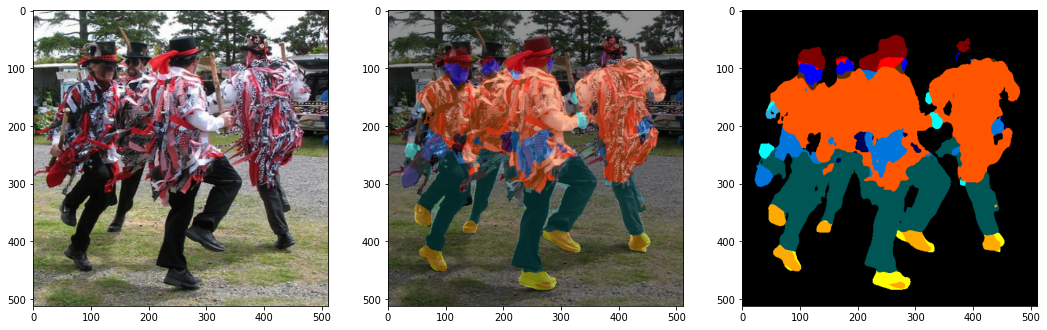

tf.Tensor(
[[[-0.62352943 -0.7254902  -0.77254903]
  [-0.6226256  -0.72458637 -0.7716452 ]
  [-0.6194087  -0.7213695  -0.7684283 ]
  ...
  [-0.06254596 -0.03941482 -0.42745095]
  [-0.06576288 -0.0361979  -0.42745095]
  [-0.06666666 -0.03529412 -0.42745095]]

 [[-0.62352943 -0.7254902  -0.77254903]
  [-0.6226256  -0.72458637 -0.7716452 ]
  [-0.6194087  -0.7213695  -0.7684283 ]
  ...
  [-0.06254596 -0.03941482 -0.42745095]
  [-0.06576288 -0.0361979  -0.42745095]
  [-0.06666666 -0.03529412 -0.42745095]]

 [[-0.62120867 -0.72316945 -0.77022827]
  [-0.62057227 -0.72253305 -0.76959187]
  [-0.61830723 -0.720268   -0.76732683]
  ...
  [-0.05558366 -0.03245252 -0.42048866]
  [-0.05880058 -0.0292356  -0.42048866]
  [-0.05970436 -0.02833182 -0.42048866]]

 ...

 [[-0.8039216  -0.8039216  -0.8039216 ]
  [-0.8039216  -0.8039216  -0.8039216 ]
  [-0.8039216  -0.8039216  -0.8039216 ]
  ...
  [-0.7882353  -0.7882353  -0.7882353 ]
  [-0.7882353  -0.7882353  -0.7882353 ]
  [-0.7882353  -0.7882353  -0.788

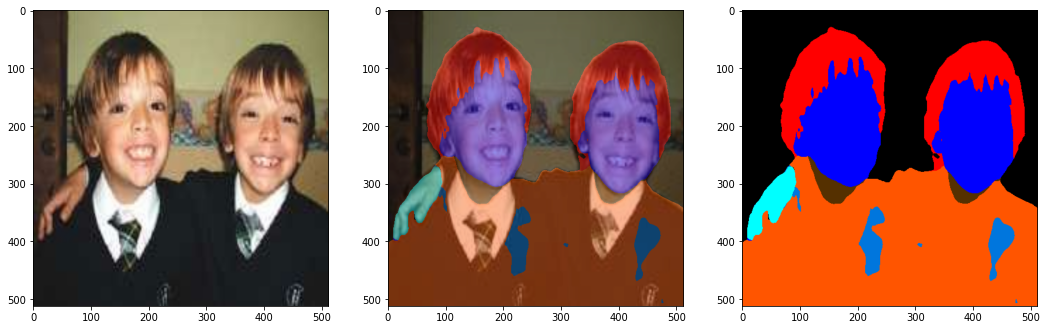

In [12]:
plot_predictions(train_images[:4], colormap, model=model)

### Inference sur les données de validation

tf.Tensor(
[[[-0.94509804 -0.9372549  -0.92156863]
  [-0.9980699  -0.9977941  -0.9821078 ]
  [-0.91139704 -0.90401345 -0.8883272 ]
  ...
  [-0.97046566 -0.97046566 -0.97046566]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.9715303  -0.96746325 -0.951777  ]
  [-0.96620953 -0.9624232  -0.94673693]
  [-0.92362493 -0.9160201  -0.9003338 ]
  ...
  [-0.98180854 -0.98180854 -0.98180854]
  [-0.95091146 -0.95091146 -0.95091146]
  [-0.95091146 -0.95091146 -0.95091146]]

 [[-1.         -1.         -0.9843137 ]
  [-0.93600225 -0.92843485 -0.9127486 ]
  [-0.945063   -0.9382221  -0.92253584]
  ...
  [-0.9948367  -0.9948367  -0.9948367 ]
  [-0.9118796  -0.9118796  -0.9118796 ]
  [-0.9118796  -0.9118796  -0.9118796 ]]

 ...

 [[-0.94577205 -0.9379289  -0.972886  ]
  [-0.9588524  -0.9510093  -0.9859664 ]
  [-0.94018507 -0.93234193 -0.96729904]
  ...
  [-0.9955687  -0.9955687  -0.9955687 ]
  [-0.925652   -0.925652   -0.925652  ]
  [-0.9607843  -0.9607843  -0.960

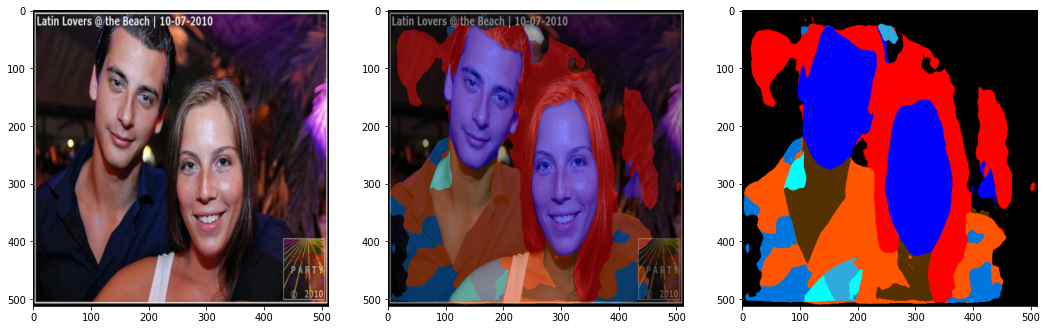

tf.Tensor(
[[[ 0.92941177  0.92941177  0.92941177]
  [ 0.93410695  0.93410695  0.93410695]
  [ 0.9372549   0.9372549   0.9372549 ]
  ...
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]]

 [[ 0.9369792   0.9369792   0.9369792 ]
  [ 0.93714416  0.93714416  0.93714416]
  [ 0.9372549   0.9372549   0.9372549 ]
  ...
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]]

 [[ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]
  [ 0.9372549   0.9372549   0.9372549 ]
  ...
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]]

 ...

 [[-0.94509804 -0.94509804 -0.9607843 ]
  [-0.94509804 -0.94509804 -0.9607843 ]
  [-0.94250154 -0.94250154 -0.9581878 ]
  ...
  [-0.6        -0.54509807 -0.4823529 ]
  [-0.6        -0.54509807 -0.4823529 ]
  [-0.6        -0.54509807 -0.482

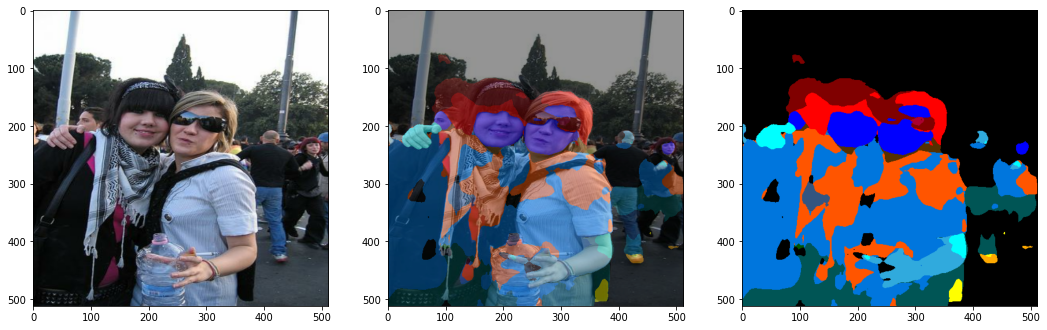

tf.Tensor(
[[[-0.09803921 -0.36470586 -0.8666667 ]
  [-0.06776959 -0.3344363  -0.83639705]
  [-0.05928308 -0.32594973 -0.82791054]
  ...
  [-0.8122549  -0.702451   -0.69368875]
  [-0.6905331  -0.5807291  -0.5571997 ]
  [-0.5921569  -0.4823529  -0.4588235 ]]

 [[-0.09430915 -0.3609758  -0.8629366 ]
  [-0.06763846 -0.3343051  -0.8362659 ]
  [-0.05928308 -0.32594973 -0.82791054]
  ...
  [-0.86951756 -0.75971365 -0.7551186 ]
  [-0.7695206  -0.6597166  -0.6473775 ]
  [-0.6891391  -0.5793352  -0.566996  ]]

 [[-0.09019607 -0.35686272 -0.85882354]
  [-0.06749386 -0.33416057 -0.8361213 ]
  [-0.05928308 -0.32594973 -0.82791054]
  ...
  [-0.9411427  -0.8360474  -0.8439518 ]
  [-0.87468046 -0.7657951  -0.7736995 ]
  [-0.82176775 -0.71097577 -0.7188802 ]]

 ...

 [[-0.9607843  -0.8745098  -0.827451  ]
  [-0.9607843  -0.8745098  -0.827451  ]
  [-0.9672377  -0.8809632  -0.8339044 ]
  ...
  [-0.02548587 -0.21372116 -0.5588193 ]
  [-0.01051158 -0.19874686 -0.54384494]
  [-0.03035384 -0.21858913 -0.563

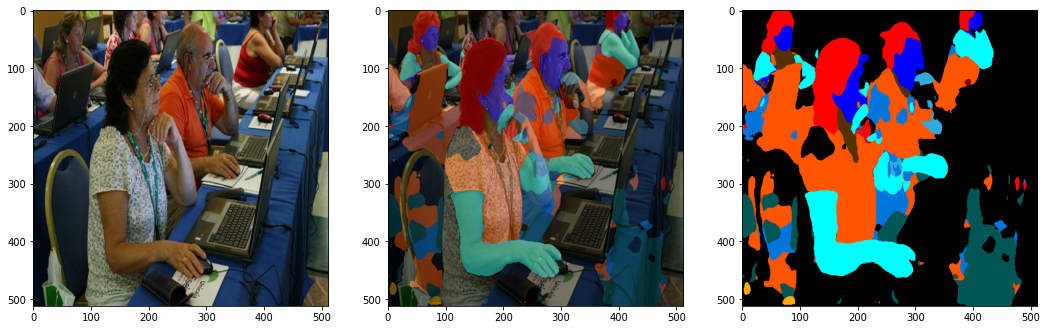

tf.Tensor(
[[[-0.09019607 -0.0745098   0.0196079 ]
  [-0.08262867 -0.06694239  0.02717519]
  [-0.07496935 -0.04451591  0.04221809]
  ...
  [-0.9137255  -0.90588236 -0.94509804]
  [-0.9137255  -0.90588236 -0.94509804]
  [-0.9137255  -0.90588236 -0.94509804]]

 [[-0.08085173 -0.06516546  0.02895224]
  [-0.06877637 -0.0530901   0.04102755]
  [-0.06095284 -0.0304994   0.05623472]
  ...
  [-0.90438116 -0.896538   -0.9357537 ]
  [-0.90438116 -0.896538   -0.9357537 ]
  [-0.90438116 -0.896538   -0.9357537 ]]

 [[-0.06683517 -0.05114889  0.04296875]
  [-0.05170035 -0.03601408  0.05810356]
  [-0.04376531 -0.01331186  0.07342219]
  ...
  [-0.9031556  -0.8953125  -0.9345282 ]
  [-0.9031556  -0.8953125  -0.9345282 ]
  [-0.9031556  -0.8953125  -0.9345282 ]]

 ...

 [[-0.9188419  -0.84041053 -0.76197916]
  [-0.9139054  -0.8127718  -0.74190784]
  [-0.9777694  -0.8831922  -0.7904532 ]
  ...
  [ 0.21312809  0.06410849 -0.37510723]
  [ 0.21312809  0.06410849 -0.37510723]
  [ 0.21312809  0.06410849 -0.375

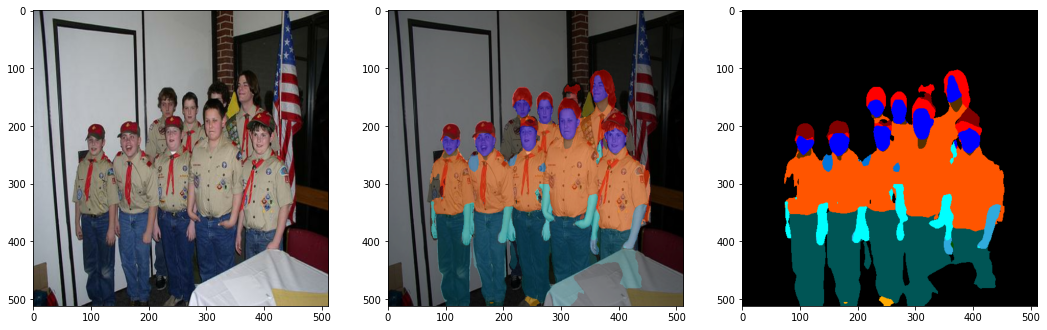

In [13]:
plot_predictions(val_images[:4], colormap, model=model)